In [2]:
import medmnist
from medmnist import INFO, Evaluator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import math

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl

In [3]:
NUM_CLIENTS = 100
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.01
n_classes = 9
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

In [4]:
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

Using downloaded and verified file: C:\Users\aaron\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\aaron\.medmnist\pathmnist.npz


In [30]:
import numpy as np
npz_file = np.load('pathmnist.npz')

X_TRAIN = npz_file['train_images']
Y_TRAIN = npz_file['train_labels']
x_val = npz_file['val_images']
y_val = npz_file['val_labels']
x_test = npz_file['test_images']
y_test = npz_file['test_labels']

In [6]:
print("Train:")
print(train_dataset)
print()
print("Test:")
print(test_dataset)

Train:
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\aaron\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE

In [7]:
# print the unique labels in the dataset
y_train = keras.utils.to_categorical(train_dataset.labels)
#x_train = train_dataset.imgs
y_val = keras.utils.to_categorical(y_val)
y_test = keras.utils.to_categorical(test_dataset.labels)
#x_test = test_dataset.imgs

# normalize the input data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
# resize the input data from 28x28 to 56x56 for resnet
x_train = tf.image.resize(x_train, (32, 32))
x_test = tf.image.resize(x_test, (32, 32))
x_val = tf.image.resize(x_val, (32, 32))

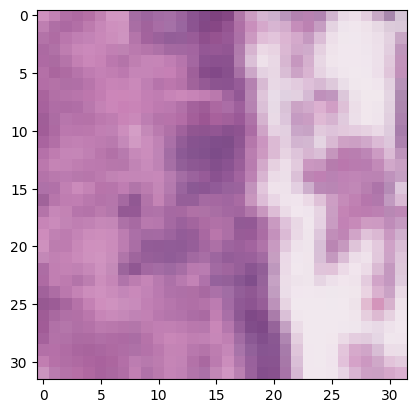

In [8]:
from matplotlib import pyplot as plt
plt.imshow(x_train[20], interpolation='nearest')
plt.show()

In [10]:
TEACHER = keras.models.Sequential([ 
    tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', pooling = 'avg', input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(9, activation='softmax')
])
# Dont train the pre-trained resnet portiont as it detects features well, just train for the output layer
TEACHER.layers[0].trainable = False
TEACHER.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()])
TEACHER.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 9)                 11529     
                                                                 
Total params: 2,269,513
Trainable params: 11,529
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
TEACHER.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
# Evaluate resnet on the test data
TEACHER.evaluate(x_test, y_test)

Epoch 1/10
2813/2813 [==============================] - 46s 16ms/step - loss: 1.5224 - accuracy: 0.4844 - categorical_accuracy: 0.4844 - val_loss: 1.3549 - val_accuracy: 0.5188 - val_categorical_accuracy: 0.5188
Epoch 2/10
2813/2813 [==============================] - 45s 16ms/step - loss: 1.3212 - accuracy: 0.5274 - categorical_accuracy: 0.5274 - val_loss: 1.2991 - val_accuracy: 0.5301 - val_categorical_accuracy: 0.5301
Epoch 3/10
2813/2813 [==============================] - 45s 16ms/step - loss: 1.2899 - accuracy: 0.5339 - categorical_accuracy: 0.5339 - val_loss: 1.2815 - val_accuracy: 0.5323 - val_categorical_accuracy: 0.5323
Epoch 4/10
2813/2813 [==============================] - 49s 17ms/step - loss: 1.2774 - accuracy: 0.5369 - categorical_accuracy: 0.5369 - val_loss: 1.2731 - val_accuracy: 0.5348 - val_categorical_accuracy: 0.5348
Epoch 5/10
2813/2813 [==============================] - 47s 17ms/step - loss: 1.2711 - accuracy: 0.5381 - categorical_accuracy: 0.5381 - val_loss: 1.269

[1.1703355312347412, 0.5870473384857178, 0.5870473384857178]

In [12]:
TEACHER.save('saved_model/MobileNetV2')

INFO:tensorflow:Assets written to: saved_model/MobileNetV2\assets


INFO:tensorflow:Assets written to: saved_model/MobileNetV2\assets


In [9]:
TEACHER = tf.keras.models.load_model('saved_model/MobileNetV2')

In [10]:
# Knowledge Distillation!

class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [11]:
student1 = keras.models.Sequential([
    layers.InputLayer(input_shape=(32, 32, 3)),
    layers.ZeroPadding2D(padding=3),
    layers.Conv2D(64, (23, 23), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.ZeroPadding2D(padding=1),
    layers.MaxPooling2D((11, 11), strides=(1, 1)),
    # layers.Conv2D(64, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    # layers.Conv2D(256, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    # layers.Conv2D(64, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    # layers.Conv2D(256, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    # layers.Conv2D(64, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    # layers.Conv2D(256, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    layers.Conv2D(64, (1, 1), activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (1, 1), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
# Initialize and compile distiller
distiller = Distiller(student=student1, teacher=TEACHER)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.CategoricalAccuracy(), 'accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

# Distill teacher to student
student_history = distiller.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val))


c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2813/2813 [==============================] - 110s 38ms/step - categorical_accuracy: 0.6369 - accuracy: 0.6369 - student_loss: 0.9581 - distillation_loss: 0.0149 - val_categorical_accuracy: 0.3497 - val_accuracy: 0.3497 - val_student_loss: 2.2359


In [12]:

# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

225/225 [==============================] - 2s 8ms/step - categorical_accuracy: 0.4219 - accuracy: 0.4219 - student_loss: 2.9703


[0.4218662977218628, 0.4218662977218628, 3.7833337783813477]

In [13]:
distiller.student.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 38, 38, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        101632    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 18, 18, 64)       0         
 ng2D)                                                           
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                      

In [14]:
distiller.student.get_weights()

[array([[[[ 1.99397281e-03, -1.87434908e-02, -4.83781025e-02, ...,
            3.51530313e-02, -3.73624917e-03,  2.37753266e-03],
          [ 4.44125338e-03, -3.99837317e-03, -5.77829108e-02, ...,
           -1.62880141e-02, -5.88900130e-03,  7.80456467e-03],
          [ 4.86529525e-03, -1.89986695e-02, -5.26610538e-02, ...,
            1.82313863e-02,  9.08873684e-04, -1.06926728e-02]],
 
         [[-1.25321122e-02, -8.31644237e-03, -3.26776020e-02, ...,
            6.99065477e-02, -1.92427374e-02, -1.52173685e-03],
          [ 5.83882071e-03, -7.23309116e-03, -4.55705039e-02, ...,
           -6.62966669e-02, -2.21686531e-02, -8.54688045e-03],
          [-1.22348554e-02,  5.22014173e-03, -2.87530199e-02, ...,
            2.07735654e-02,  4.51759528e-03, -1.05592990e-02]],
 
         [[ 7.33120134e-03,  5.71837276e-03, -3.42881605e-02, ...,
            6.38826191e-02, -1.02235265e-02,  1.35743394e-02],
          [-9.58534144e-03, -9.35591571e-03, -4.31851670e-02, ...,
           -7.769

In [26]:
test_clone = keras.models.clone_model(distiller.student)

In [27]:
test_clone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 38, 38, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        101632    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 18, 18, 64)       0         
 ng2D)                                                           
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                      

In [28]:
class FlwrClient(fl.client.NumPyClient):
    def __init__(self, model, x_train, y_train) -> None:
        super().__init__()
        self.model = model
        split_idx = math.floor(len(x_train) * 0.9)  # Use 10% of x_train for validation
        self.x_train, self.y_train = x_train[:split_idx], y_train[:split_idx]
        self.x_val, self.y_val = x_train[split_idx:], y_train[split_idx:]

    def get_parameters(self, config):
        return self.model.student.get_weights()

    def fit(self, parameters, config):
        self.model.student.set_weights(parameters)
        self.model.fit(self.x_train, self.y_train, epochs=2, verbose=2)
        return self.model.student.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.student.set_weights(parameters)
        loss, acc = self.model.student.evaluate(self.x_val, self.y_val, verbose=2)
        return loss, len(self.x_val), {"accuracy": acc}

In [31]:
def client_fn(cid: str) -> fl.client.Client:
    # Load model
    student = keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
        # tf.keras.layers.ZeroPadding2D(padding=3),
        # tf.keras.layers.Conv2D(64, (23, 23), activation='relu', input_shape=(32, 32, 3)),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.ZeroPadding2D(padding=1),
        # tf.keras.layers.MaxPooling2D((11, 11), strides=(1, 1)),
        # tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(256, (1, 1), activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(256, (1, 1), activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Conv2D(256, (1, 1), activation='relu'),
        # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (1, 1), activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    # Initialize and compile distiller
    model = Distiller(student=student, teacher=TEACHER)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.CategoricalAccuracy(), 'accuracy'],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1,
        temperature=10,
    )


    # Load data partition (divide MNIST into NUM_CLIENTS distinct partitions)
    partition_size = math.floor(len(X_TRAIN) / NUM_CLIENTS)
    idx_from, idx_to = int(cid) * partition_size, (int(cid) + 1) * partition_size
    x_train_cid = X_TRAIN[idx_from:idx_to] / 255.0
    y_train_cid = Y_TRAIN[idx_from:idx_to]

    # Create and return client
    return FlwrClient(model, x_train_cid, y_train_cid)

In [32]:
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    client_resources={"num_cpus": 4},
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(
        fraction_fit=0.1,
        fraction_evaluate=0.1,
        min_fit_clients=10,
        min_evaluate_clients=10,
        min_available_clients=NUM_CLIENTS,
    ),
)

INFO flwr 2023-04-16 20:03:13,680 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2023-04-16 20:03:18,139	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-04-16 20:03:19,787 | app.py:179 | Flower VCE: Ray initialized with resources: {'GPU': 1.0, 'CPU': 16.0, 'memory': 11378486478.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 5689243238.0}
INFO flwr 2023-04-16 20:03:19,789 | server.py:86 | Initializing global parameters
INFO flwr 2023-04-16 20:03:19,789 | server.py:270 | Requesting initial parameters from one random client
DEBUG flwr 2023-04-16 20:03:23,158 | ray_client_proxy.py:72 | ray::launch_and_get_parameters() (pid=15536, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 789, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 814, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 506, in ray._raylet.raise_if_dependency_failed
ray.exceptions

RayTaskError: [36mray::launch_and_get_parameters()[39m (pid=15536, ip=127.0.0.1)
  File "python\ray\_raylet.pyx", line 789, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 814, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 506, in ray._raylet.raise_if_dependency_failed
ray.exceptions.RaySystemError: System error: Error when deserializing class 'ReLU' using config={'name': 'Conv1_relu', 'trainable': False, 'dtype': 'float32', 'max_value': {'class_name': '__numpy__', 'config': {'value': 6.0, 'dtype': 'float32'}}, 'negative_slope': {'class_name': '__numpy__', 'config': {'value': 0.0, 'dtype': 'float32'}}, 'threshold': {'class_name': '__numpy__', 'config': {'value': 0.0, 'dtype': 'float32'}}}.

Exception encountered: '<' not supported between instances of 'dict' and 'float'
traceback: Traceback (most recent call last):
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\engine\base_layer.py", line 868, in from_config
    return cls(**config)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\layers\activation\relu.py", line 79, in __init__
    if max_value is not None and max_value < 0.0:
TypeError: '<' not supported between instances of 'dict' and 'float'

During handling of the above exception, another exception occurred:

[36mray::launch_and_get_parameters()[39m (pid=15536, ip=127.0.0.1)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\ray\_private\serialization.py", line 369, in deserialize_objects
    obj = self._deserialize_object(data, metadata, object_ref)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\ray\_private\serialization.py", line 252, in _deserialize_object
    return self._deserialize_msgpack_data(data, metadata_fields)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\ray\_private\serialization.py", line 207, in _deserialize_msgpack_data
    python_objects = self._deserialize_pickle5_data(pickle5_data)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\ray\_private\serialization.py", line 195, in _deserialize_pickle5_data
    obj = pickle.loads(in_band, buffers=buffers)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\pickle_utils.py", line 48, in deserialize_model_from_bytecode
    raise e
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\pickle_utils.py", line 46, in deserialize_model_from_bytecode
    model = saving_lib.load_model(filepath, safe_mode=False)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\saving_lib.py", line 277, in load_model
    raise e
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\saving_lib.py", line 242, in load_model
    model = deserialize_keras_object(
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\serialization_lib.py", line 502, in deserialize_keras_object
    instance = cls.from_config(inner_config)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\engine\sequential.py", line 476, in from_config
    layer = layer_module.deserialize(
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\layers\serialization.py", line 265, in deserialize
    return legacy_serialization.deserialize_keras_object(
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\legacy\serialization.py", line 503, in deserialize_keras_object
    deserialized_obj = cls.from_config(
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\engine\training.py", line 3053, in from_config
    inputs, outputs, layers = functional.reconstruct_from_config(
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\engine\functional.py", line 1483, in reconstruct_from_config
    process_layer(layer_data)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\engine\functional.py", line 1464, in process_layer
    layer = deserialize_layer(layer_data, custom_objects=custom_objects)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\layers\serialization.py", line 265, in deserialize
    return legacy_serialization.deserialize_keras_object(
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\saving\legacy\serialization.py", line 513, in deserialize_keras_object
    deserialized_obj = cls.from_config(cls_config)
  File "c:\Users\aaron\anaconda3\envs\flowerenv\lib\site-packages\keras\engine\base_layer.py", line 870, in from_config
    raise TypeError(
TypeError: Error when deserializing class 'ReLU' using config={'name': 'Conv1_relu', 'trainable': False, 'dtype': 'float32', 'max_value': {'class_name': '__numpy__', 'config': {'value': 6.0, 'dtype': 'float32'}}, 'negative_slope': {'class_name': '__numpy__', 'config': {'value': 0.0, 'dtype': 'float32'}}, 'threshold': {'class_name': '__numpy__', 'config': {'value': 0.0, 'dtype': 'float32'}}}.

Exception encountered: '<' not supported between instances of 'dict' and 'float'